In [58]:
import matplotlib.pyplot as plt #plotting
import numpy as np #vectorized operations
import pandas as pd #data analysis


import pandas_datareader as pdr #wrapper to import data
import datetime as dt #date-time objects

import statsmodels.api as sms ## X and Y are the inputs, their dimen need to match!!

import statsmodels.api as sm
from stargazer.stargazer import Stargazer
import statsmodels.formula.api as sma
import seaborn as sns

In [59]:
#NASDAQ DATA, We choose ignore expectation variables and only use coincident indicators because our objective is
#to compare current economic health to current indice prices alone and see which indice prices shifted relatively more.
#We are not concerned with the forecasting of stock prices.

DataNas = pd.read_csv('F:/MATH 408/NASDAQPRICE.csv')
for i in [DataNas]:
    i['ret'] = close_to_close_returns(i['Close'])*100
DataNas=DataNas.dropna()
DataNas['logret']=np.log(np.abs(DataNas['ret']))

#Unemployment
DataUE=pd.read_csv('F:/MATH 408/UNRATE.csv')
DataUE=DataUE[624:877]
DataUE.index = np.arange(1,len(DataUE)+1)

#Real GDP
DataGDP=pd.read_csv('F:/MATH 408/US-Monthly-GDP-History-Data.csv')
DataGDP=DataGDP.dropna()
DataGDP=DataGDP[95:349]
for i in [DataGDP]:
    i['Adj_RGDP'] = close_to_close_returns(i['Monthly Real GDP Index'])
DataGDP=DataGDP.dropna()
DataGDP.index = np.arange(1,len(DataGDP)+1)

#Consumer Price Index
DataCPI=pd.read_csv('F:/MATH 408/CPIAUCSL.csv')
DataCPI=DataCPI[636:889]
DataCPI.index = np.arange(1,len(DataCPI)+1)

#Producer Price Index
DataPPI=pd.read_csv('F:/MATH 408/PPIACO.csv')
DataPPI=DataPPI[1044:1297]
DataPPI.index=np.arange(1,len(DataPPI)+1)

#Personal Consumption Expenditure (Personal Spending)
DataPCE=pd.read_csv('F:/MATH 408/PCE.csv')
DataPCE=DataPCE[492:745]
DataPCE.index=np.arange(1,len(DataPCE)+1)
DataReg=pd.DataFrame({'Date':DataNas['Date'],'price':DataNas['Close'],'RGDP':DataGDP['Monthly Real GDP Index'],'UE':DataUE['UNRATE'],'CPI':DataCPI['CPIAUCSL'],'PPI':DataPPI['PPIACO'],'PCE':DataPCE['PCE']})
DataReg1=pd.DataFrame({'price':DataNas['Close'],'RGDP':DataGDP['Monthly Real GDP Index'],'UE':DataUE['UNRATE'],'CPI':DataCPI['CPIAUCSL'],'PPI':DataPPI['PPIACO'],'PCE':DataPCE['PCE']})
Datalog=pd.DataFrame({'Date':DataNas['Date'],'price':DataNas['logret'],'RGDP':DataGDP['Monthly Real GDP Index'],'UE':DataUE['UNRATE'],'CPI':DataCPI['CPIAUCSL'],'PPI':DataPPI['PPIACO'],'PCE':DataPCE['PCE']})


<ipython-input-59-9d63eff80745>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DataNas['logret']=np.log(np.abs(DataNas['ret']))


In [19]:
# Adjusted Close prices
def close_to_close_returns(adj_close): 
    return adj_close / adj_close.shift() - 1 # use the shift function to compute the daily returns

# X is the matrix, Y is the column vector, we want to find \hat\beta
def multi_lin_least_squares_parameters(X, Y): 
    X = sm.add_constant(X).values
    Y = Y.values
    if np.linalg.det(np.matmul(X.transpose(),X))==0: 
        return print('Data matrix is not invertible')
    else:
        return np.matmul(np.linalg.inv(np.matmul(X.transpose(),X)), np.matmul(X.transpose(),Y)) #(X^TX)^{-1}X^TY=\hat \beat
    
def multi_lin_best_fit_plane(X,Y):
    import statsmodels.api as sm
    X = sm.add_constant(X)
    params = multi_lin_least_squares_parameters(X,Y)
    Y_hat = np.matmul(X.values, params)
    return Y_hat

In [21]:
ml_params2=multi_lin_least_squares_parameters(DataReg[['RGDP','UE','CPI','PPI','PCE']],DataReg['price'])
ml_params2

array([ 2.97826779e+04, -3.46032967e+00, -2.19205979e+02, -1.56453256e+01,
       -5.10968470e+01,  4.09385532e+00])

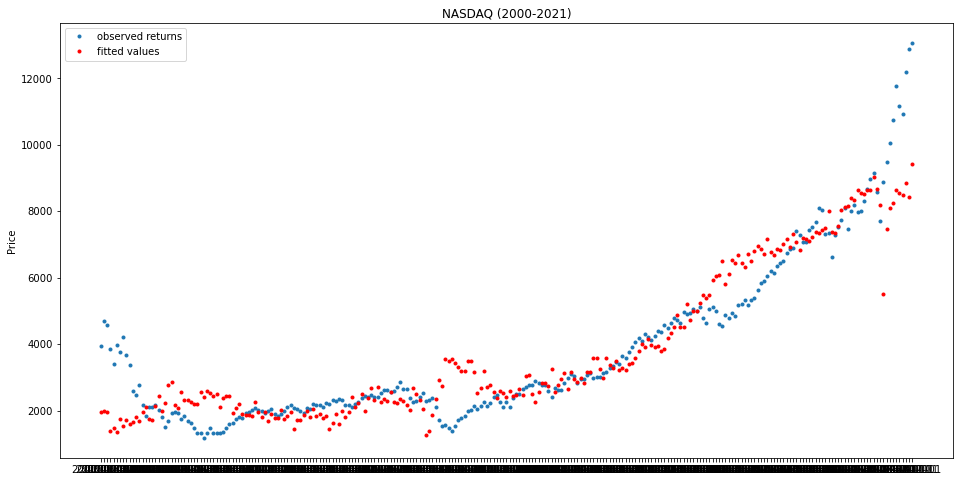

In [22]:
plt.figure(figsize=(16,8))
plt.title('NASDAQ (2000-2021)')
plt.ylabel('Price')
plt.plot(DataReg['Date'],DataReg['price'],'.',label='observed returns')
plt.plot(DataReg['Date'],multi_lin_best_fit_plane(DataReg[['RGDP','UE','CPI','PPI','PCE']], DataReg['price']),'r.', label='fitted values')
plt.legend();

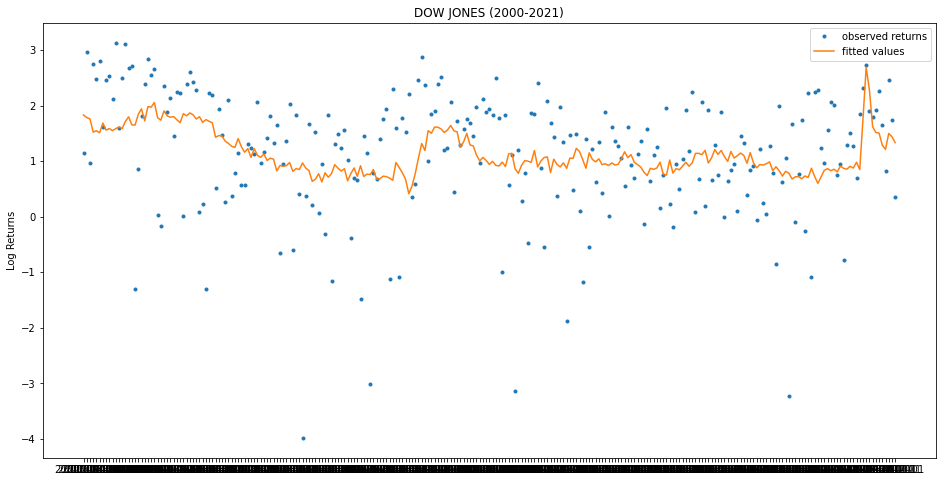

In [25]:
plt.figure(figsize=(16,8))
plt.title('DOW JONES (2000-2021)')
plt.ylabel('Log Returns')
plt.plot(DataNas['Date'],Datalog['price'],'.',label='observed returns')
plt.plot(DataNas['Date'],multi_lin_best_fit_plane(Datalog[['RGDP','UE','CPI','PPI','PCE']], Datalog['price']), label='fitted values')
plt.legend();

In [56]:
model2=sma.ols('price ~ RGDP + UE + CPI + PPI + PCE',DataReg).fit()
print(model2.params)

Intercept    29782.677914
RGDP            -3.460330
UE            -219.205979
CPI            -15.645326
PPI            -51.096847
PCE              4.093855
dtype: float64


In [28]:
model3=sma.ols('price ~ RGDP + UE + PCE + PPI + CPI',Datalog).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     6.299
Date:                Sat, 24 Apr 2021   Prob (F-statistic):           1.60e-05
Time:                        11:56:25   Log-Likelihood:                -372.49
No. Observations:                 253   AIC:                             757.0
Df Residuals:                     247   BIC:                             778.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.2501      6.965      1.472      0.1

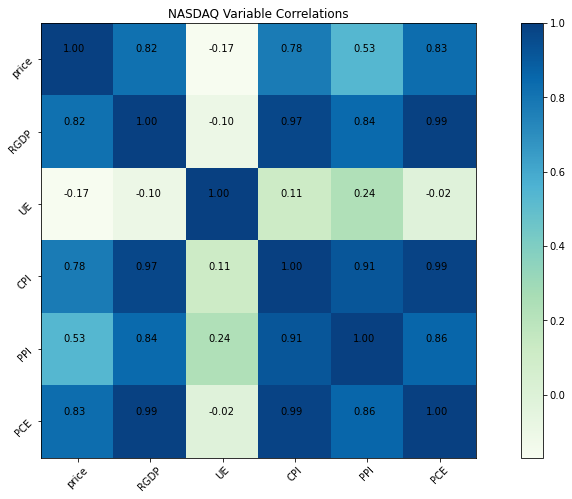

In [55]:
plt.figure(figsize=(16,8))
plt.imshow(DataReg1.corr(),cmap=plt.cm.GnBu,interpolation='nearest',data=True)
plt.colorbar()
tick_marks=[i for i in range(len(DataReg1.columns))]
plt.xticks(tick_marks,DataReg1.columns, rotation=45)
plt.yticks(tick_marks,DataReg1.columns, rotation=45)
plt.title('NASDAQ Variable Correlations')

for i in range(len(DataReg1.columns)):
    for j in range(len(DataReg1.columns)):
        text = '%.2f'%(DataReg1.corr().iloc[i,j])
        plt.text(i-0.2,j-0.1,text)

In [54]:
print(model2.summary())
#F-significantly large   
#Good R-Squared value

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     7.384
Date:                Sat, 24 Apr 2021   Prob (F-statistic):            0.00704
Time:                        13:31:18   Log-Likelihood:                -2330.1
No. Observations:                 253   AIC:                             4664.
Df Residuals:                     251   BIC:                             4671.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5096.0396    487.555     10.452      0.0

In [57]:
stargazer = Stargazer([model2, model3])
stargazer

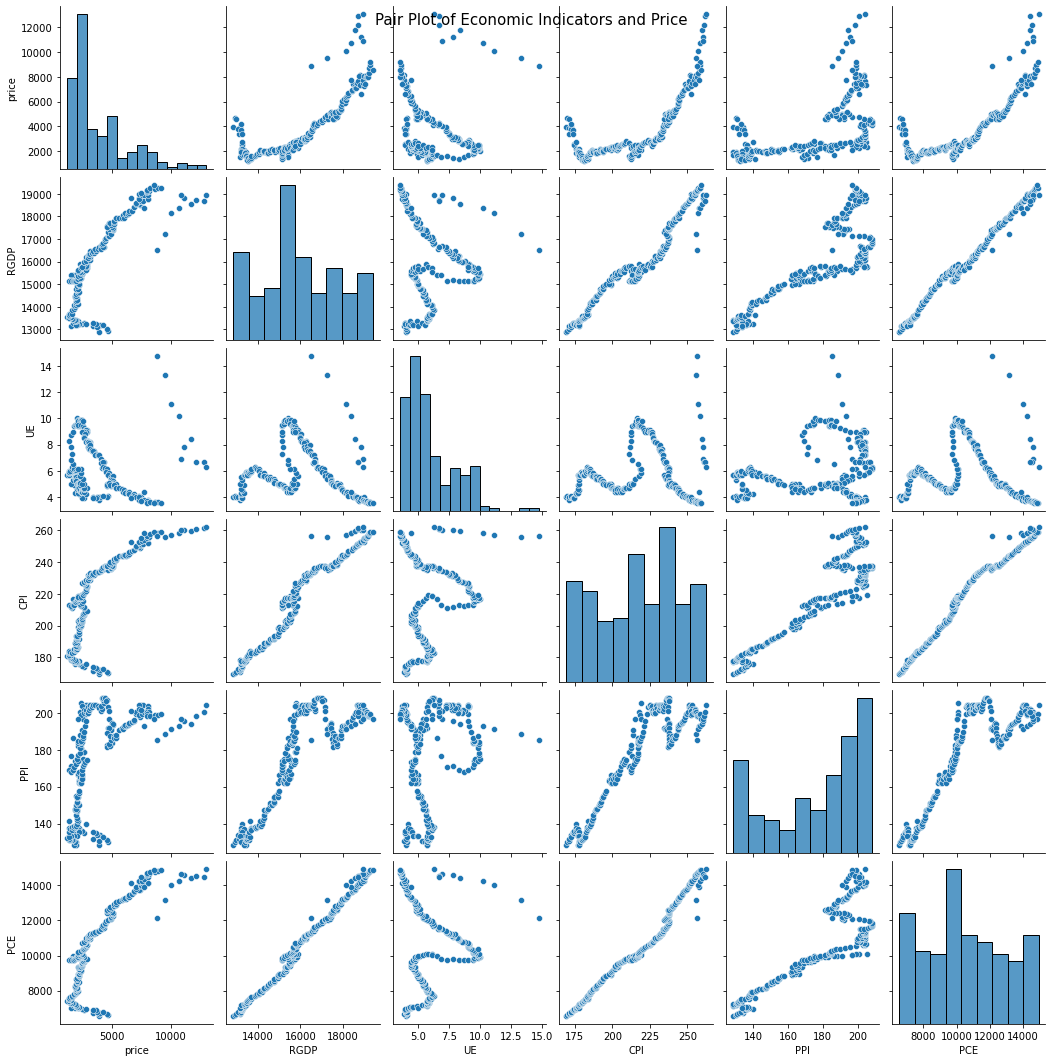

In [61]:
sns.pairplot(DataReg)
plt.suptitle('Pair Plot of Economic Indicators and Price', 
             size = 15);